In [ ]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import DataLoader

from mutation_dataset import MutationDataset
from nbvae import NBVAE, nbvae_loss

plt.style.use("dark_background")

### Method
[Variational Autoencoders for Sparse and
Overdispersed Discrete Data](https://arxiv.org/pdf/1905.00616), which is designed to simulate sparse inputs better than a standard VAE.

### Data
Extracted from [cBioPortal](https://www.cbioportal.org/study/summary?id=breast_msk_2018) and contains VCFs for tumour genomes extracted from metastases of breast cancer. We've got around 2,000 samples in total, with 451 genes and 15 variant types sequenced.

In [2]:
PROJECT_ROOT = Path('/Users/jacobbradley/Documents/NBVAE')
RAW_BRCA_DATA = PROJECT_ROOT / 'data' / 'breast_msk_2018'

RAW_MUT_DATA = RAW_BRCA_DATA / 'data_mutations.txt'
RAW_SAMPLE_DATA = RAW_BRCA_DATA / 'data_clinical_sample.txt'

In [3]:
samples = pd.read_csv(RAW_SAMPLE_DATA, sep='\t', comment='#').set_index('SAMPLE_ID')
mutations = pd.read_csv(RAW_MUT_DATA, sep='\t', comment='#')
# mutations = mutations[mutations.Hugo_Symbol.isin(['TP53', 'KRAS', 'APC'])]
# mutations = mutations[mutations.Variant_Classification.isin(['Missense_Mutation', 'Nonsense_Mutation'])]

### Form Datasets

In [ ]:
train_samples, val_samples = train_test_split(samples, test_size=.3, random_state=1234)

train_data = MutationDataset(mutations, samples=train_samples)
val_data = MutationDataset(mutations, samples=val_samples)

### Train Model

In [5]:
lr = 3e-3
batch_size = 10
n_epochs = 50
kld_weight=1e-12

model = NBVAE(
    n_genes=len(train_data.genes), 
    n_variants=len(train_data.variants), 
    n_gene_signatures=2, 
    n_variant_signatures=5, 
    latent_dim=3
)
optimizer = Adam(model.parameters(), lr=lr)

In [6]:
print("Start training VAE...")
train_data.dense = True
val_data.dense = True
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    overall_train_loss = 0
    model.train()
    for train_batch_idx, train_batch in enumerate(DataLoader(train_data, batch_size=batch_size)):
        
        optimizer.zero_grad()

        batch_reconstruction_r, batch_reconstruction_p, mean, logvar = model(train_batch)
        loss = nbvae_loss(train_batch, batch_reconstruction_r, batch_reconstruction_p, mean, logvar, kld_weight)

        overall_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    overall_val_loss = 0
    model.eval()
    for val_batch_idx, val_batch in enumerate(DataLoader(val_data, batch_size=batch_size)):
        batch_reconstruction_r, batch_reconstruction_p, mean, logvar = model(val_batch)
        loss = nbvae_loss(val_batch, batch_reconstruction_r, batch_reconstruction_p, mean, logvar, kld_weight)
        overall_val_loss += loss.item()

    train_losses.append(overall_train_loss / train_batch_idx)
    val_losses.append(overall_val_loss / val_batch_idx)

    messages = [
        f"Epoch {epoch + 1} complete! "
        f"Average Train Loss: {train_losses[-1]: .3f}, " 
        f"Average Val Loss: {val_losses[-1]: .3f} "
    ]

    if val_losses[-1] == np.nanmin(val_losses):
        messages.append(f"(Saving Model)")
        saved_model = deepcopy(model)

    print(*messages)

print("Finish!!")

Start training VAE...
Epoch 1 complete! Average Train Loss:  1470.209, Average Val Loss:  337.696  (Saving Model)
Epoch 2 complete! Average Train Loss:  148.413, Average Val Loss:  80.536  (Saving Model)
Epoch 3 complete! Average Train Loss:  65.274, Average Val Loss:  53.170  (Saving Model)
Epoch 4 complete! Average Train Loss:  48.604, Average Val Loss:  43.566  (Saving Model)
Epoch 5 complete! Average Train Loss:  41.680, Average Val Loss:  38.490  (Saving Model)
Epoch 6 complete! Average Train Loss:  38.215, Average Val Loss:  36.327  (Saving Model)
Epoch 7 complete! Average Train Loss:  36.900, Average Val Loss:  35.202  (Saving Model)
Epoch 8 complete! Average Train Loss:  35.540, Average Val Loss:  34.696  (Saving Model)
Epoch 9 complete! Average Train Loss:  34.567, Average Val Loss:  33.977  (Saving Model)
Epoch 10 complete! Average Train Loss:  33.949, Average Val Loss:  33.221  (Saving Model)
Epoch 11 complete! Average Train Loss:  33.039, Average Val Loss:  32.232  (Saving 

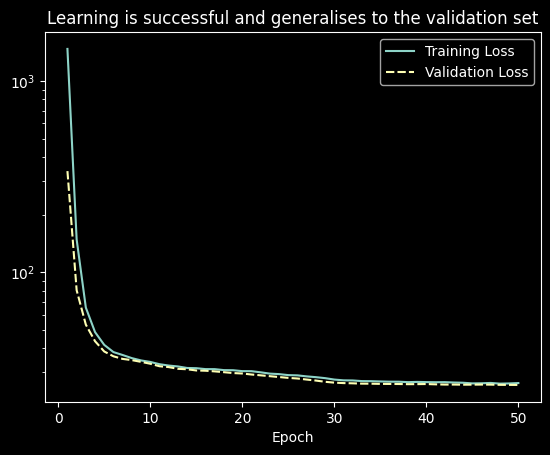

In [7]:
losses = pd.DataFrame({'Epoch': np.arange(1, n_epochs + 1), 'Training Loss': train_losses, 'Validation Loss': val_losses})
sns.lineplot(data=losses.set_index('Epoch'))
plt.yscale('log')
plt.title('Learning is successful and generalises to the validation set')
plt.show()

### Visualise Latents

In [21]:
val_vis_data = val_samples[['TMB_NONSYNONYMOUS', 'CANCER_TYPE_DETAILED', 'OVERALL_TUMOR_GRADE', 'ER_STATUS', 'SAMPLE_TYPE', 'SAMPLE_SITE']]
latents = [saved_model.get_latent(val_data[idx])[0].detach().tolist() for idx in range(len(val_samples))]
val_vis_data.loc[:, ['Latent Dim. 1', 'Latent Dim. 2', 'Latent Dim. 3']] = pd.DataFrame(latents, columns=['Latent Dim. 1', 'Latent Dim. 2', 'Latent Dim. 3'], index=val_vis_data.index)

In [24]:
fig = px.scatter_3d(val_vis_data, x='Latent Dim. 1', y='Latent Dim. 2', z='Latent Dim. 3', color='SAMPLE_SITE', template='plotly_dark')
fig.show()

In [23]:
fig = px.scatter_3d(val_vis_data, x='Latent Dim. 1', y='Latent Dim. 2', z='Latent Dim. 3', color='TMB_NONSYNONYMOUS', template='plotly_dark')
fig.show()

### Simulating 

True VCF (lightly mutated sample):

In [11]:
val_data.get_mutations('P-0012824-T01-IM5')

,Hugo_Symbol,Variant_Classification
Tumor_Sample_Barcode,,
P-0012824-T01-IM5,PIK3CA,Missense_Mutation


Simulated VCF (lightly mutated sample):

In [27]:
val_data.get_mutations(saved_model.sample_from_input(val_data['P-0012824-T01-IM5']))

,Hugo_Symbol,Variant_Classification
0,RB1,Frame_Shift_Ins
1,PIK3CA,Missense_Mutation


True VCF (heavily mutated sample):

In [13]:
val_data.get_mutations('P-0003054-T01-IM5')

,Hugo_Symbol,Variant_Classification
Tumor_Sample_Barcode,,
P-0003054-T01-IM5,ERBB2,Missense_Mutation
P-0003054-T01-IM5,PTEN,Frame_Shift_Del
P-0003054-T01-IM5,TP63,Nonsense_Mutation
P-0003054-T01-IM5,TP53,Missense_Mutation
P-0003054-T01-IM5,PIK3R3,Missense_Mutation
P-0003054-T01-IM5,SF3B1,Missense_Mutation
P-0003054-T01-IM5,PBRM1,Missense_Mutation
P-0003054-T01-IM5,EPHA3,Missense_Mutation
P-0003054-T01-IM5,ATR,Missense_Mutation


Simulated VCF (heavily mutated sample):

In [30]:
val_data.get_mutations(saved_model.sample_from_input(val_data['P-0003054-T01-IM5']))

,Hugo_Symbol,Variant_Classification
0,PTEN,Nonsense_Mutation
1,CDH1,Missense_Mutation
2,PIK3CA,Missense_Mutation
3,PIK3CA,Frame_Shift_Del
4,ESR1,Missense_Mutation
5,JUN,Missense_Mutation
6,TP53,Splice_Site
7,MGA,Missense_Mutation
8,TERT,Missense_Mutation
9,PAK7,Missense_Mutation
